In [1]:
from IPython.utils import io
with io.capture_output() as captured:
    !pip install scispacy
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [1]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
import en_core_sci_lg

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [2]:
df = pd.read_csv('../covid_data/Data/cord19_df/cord19_df.csv')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,paper_id,body_text,methods,results,source,title,doi,abstract,publish_time,authors,journal,arxiv_id,url,publish_year,is_covid19,study_design
0,3cdc48bb9e40afd30a59463b7872761a726998c8,NDV (Roakin strain) was obtained from Dr. D. J...,NDV (Roakin strain) was obtained from Dr. D. J...,Adult house flies harbored Newcastle Disease v...,PMC,Experimental Evaluation of Musca domestica (Di...,10.1093/jmedent/44.4.666,"House flies, Musca domestica L. (Diptera: Musc...",2007-07-01,"Watson, D. Wes; Niño, Elina L.; Rochon, Katery...",J Med Entomol,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,2007,False,[]
1,d99acb4e99be7852aa61a688c9fbd38d44b5a252,Live attenuated viruses have been developed an...,RSV A2 strain was obtained from ATCC (Manassas...,The reverse genetics system for measles Edmons...,PMC,Evaluation of Measles Vaccine Virus as a Vecto...,10.2174/1874357901206010012,Live attenuated recombinant measles vaccine vi...,2012-02-16,"Mok, Hoyin; Cheng, Xing; Xu, Qi; Zengel, James...",Open Virol J,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,2012,False,"['truncated', 'gamma', 'protocol']"
2,748d4c57fe1acc8d9d97cf574f7dea5296f9386c,Ebola virus (EBOV) and other members of the fa...,U2OS human osteosarcoma cells were cultured in...,For evaluating EBOV GP triggering under biosaf...,PMC,Direct Visualization of Ebola Virus Fusion Tri...,10.1128/mbio.01857-15,Ebola virus (EBOV) makes extensive and intrica...,2016-02-09,"Spence, Jennifer S.; Krause, Tyler B.; Mittler...",mBio,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,2016,False,"['truncated', 'heterogeneity']"
3,b891efc6e1419713b05ff7d89b26d260478c28df,To the Editor:\nChina has the world's second l...,NaN,NaN,PMC,Tuberculosis prevention in healthcare workers ...,10.1183/23120541.00015-2015,BSL3 and respiratory isolation wards protect h...,2015-08-21,"Deng, Yunfeng; Li, Yan; Wang, Fengtian; Gao, D...",ERJ Open Res,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,2015,False,[]
4,353852971069ad5794445e5c1ab6077ce23da75d,Coronavirus disease 2019 (COVID-19) has spread...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,True,[]


In [3]:
all_texts = df.body_text
print(all_texts[0][:500])

NDV (Roakin strain) was obtained from Dr. D. J. King, Southeast Poultry Research Laboratory, Athens, GA. The virus was propagated by inoculation of 10-d-old embryonated chicken eggs by the allantoic route, 0.1 ml per egg (SPAFAS, Charles River Laboratories Inc., Wilmington, MA). Allantoic fluid was harvested from eggs that died 3–4 d postinoculation. Titration of the virus was accomplished by preparation of 10-fold dilutions of allantoic fluid in Dulbecco's minimal essential medium (DMEM) and in


In [4]:
nlp = en_core_sci_lg.load(disable=['tagger','parser','ner'])
nlp.max_length = 3000000

In [5]:
# pip install spacy==2.2.4

Note: you may need to restart the kernel to use updated packages.


In [6]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or
                                                         word.is_punct or word.is_space or len(word)==1)]

In [7]:
# Here we are downloading Wordcloud to create wordcloud based on the column values using textmining

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [8]:
body_text = " ".join(text for text in df['body_text'])

In [19]:
(print(len(body_text[:50000000])))

50000000


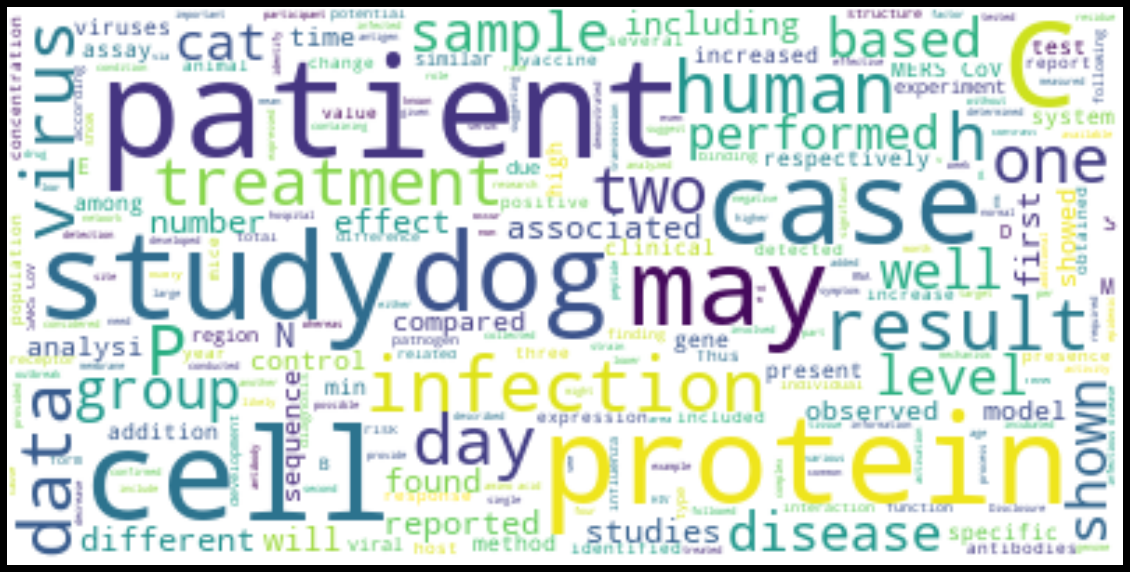

In [13]:
# generating Wordcloud based on the frequency of word.

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update([    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym',
    r'\setlength{\oddsidemargin}{-69pt',  r'\usepackage{upgreek', r'\documentclass[12pt]{minimal','although','within'])

wc = WordCloud(background_color="white", max_words=2000, stopwords=stopwords, max_font_size=50,
            contour_width=3, contour_color='firebrick')
wc.generate(body_text[:5000000])
plt.figure(figsize=(20,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym',
    r'\setlength{\oddsidemargin}{-69pt',  r'\usepackage{upgreek', r'\documentclass[12pt]{minimal'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [16]:
filepath = '../input/topic-modeling-finding-related-articles/'

In [17]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
data_vectorized = vectorizer.fit_transform(tqdm(all_texts))

100%|█████████████████| 47110/47110 [29:00<00:00, 27.06it/s]


In [18]:
data_vectorized.shape

(47110, 541125)

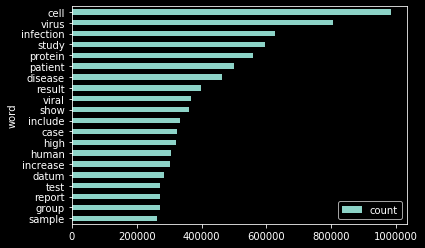

In [19]:
# most frequent words
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [21]:
joblib.dump(vectorizer, '../topic-modeling-finding-related-articles/vectorizer.csv')
joblib.dump(data_vectorized, '../topic-modeling-finding-related-articles/data_vectorized.csv')

['../topic-modeling-finding-related-articles/data_vectorized.csv']

In [26]:
lda = LatentDirichletAllocation(n_components = 50, random_state=0,learning_method='online',verbose=1)
lda.fit(data_vectorized)
joblib.dump(lda,'../topic-modeling-finding-related-articles/lda.csv')

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


['../topic-modeling-finding-related-articles/lda.csv']

In [27]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [28]:
print_top_words(lda, vectorizer, n_top_words=25)


Topic #0: blood test plasma donor product transfusion platelet sample unit p. process result red inactivation screen study pcv2 reaction pool antibody safety positive donation storage type

Topic #1: protein membrane fusion domain cell acid mutant amino contain site process sequence cleavage protease form activity show er region function express suggest residue complex encode

Topic #2: sars-cov mers-cov coronavirus sars human cov respiratory camel mers spike animal infection study covs rbd bat severe dpp4 viral syndrome s1 middle virus report patient

Topic #3: gene expression target sirna mrna vector express cell promoter transcript dna plasmid level protein rna transcription control sirnas transfection silence transfect genome reporter pathway rnai

Topic #4: health public disease research need system provide include information risk country work new global service state care development response government issue plan national people international

Topic #5: model time numb rate va

In [31]:
doc_topic_dist = pd.DataFrame(lda.transform(data_vectorized))
doc_topic_dist.to_csv('../topic-modeling-finding-related-articles/doc_topic_dist.csv', index=False)

In [32]:
doc_topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.009452,0.000014,0.000014,0.010177,0.001276,0.017239,0.140493,0.000014,0.000014,0.000014,...,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014
1,0.000007,0.000007,0.000007,0.026468,0.000007,0.000007,0.177363,0.000007,0.000007,0.000007,...,0.000007,0.000007,0.042212,0.000007,0.009549,0.000007,0.000007,0.422698,0.002827,0.056158
2,0.000007,0.203549,0.000007,0.010034,0.003828,0.015899,0.095299,0.000007,0.000007,0.010066,...,0.000007,0.000007,0.282044,0.000007,0.000007,0.000007,0.000007,0.005721,0.003749,0.000007
3,0.000032,0.010201,0.000032,0.000032,0.045060,0.000032,0.009011,0.000032,0.000032,0.016270,...,0.000032,0.000032,0.000032,0.003720,0.000032,0.000032,0.000032,0.007538,0.276761,0.014606
4,0.000039,0.000039,0.000039,0.000039,0.342898,0.094446,0.000039,0.000039,0.000039,0.062805,...,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.006979,0.000039


In [34]:
is_covid19_article = df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus|Corona|Corona virus')

In [35]:
def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2020, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        temp = doc_topic_dist[relevant_time & is_covid19_article]
        
    else:
        temp = doc_topic_dist[relevant_time]
         
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

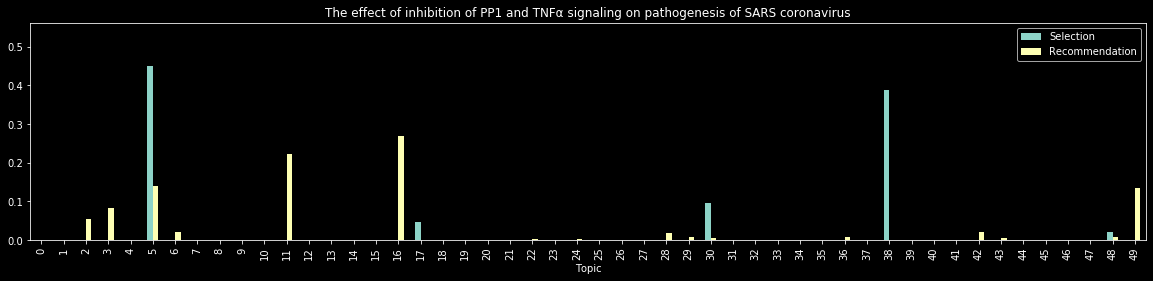

In [50]:
# def plot_article_dna(paper_id, width=20):
#     t = df[df.paper_id == paper_id].title.values[0]
#     doc_topic_dist[df.paper_id == paper_id].T.plot(kind='bar', legend=None, title=t, figsize=(width, 4))
#     plt.xlabel('Topic')

def compare_dnas(paper_id, recommendation_id, width=20):
    t = df[df.paper_id == recommendation_id].title.values[0]
    temp = doc_topic_dist[df.paper_id == paper_id]
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, doc_topic_dist[df.paper_id == recommendation_id]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])

compare_dnas('90b5ecf991032f3918ad43b252e17d1171b4ea63', 'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a')

# def dna_tabs(paper_ids):
#     k = len(paper_ids)
#     outs = [widgets.Output() for i in range(k)]

#     tab = widgets.Tab(children = outs)
#     tab_titles = ['Paper ' + str(i+1) for i in range(k)]
#     for i, t in enumerate(tab_titles):
#         tab.set_title(i, t)
#     display(tab)

#     for i, t in enumerate(tab_titles):
#         with outs[i]:
#             ax = plot_article_dna(paper_ids[i])
#             plt.show(ax)

# def compare_tabs(paper_id, recommendation_ids):
#     k = len(recommendation_ids)
#     outs = [widgets.Output() for i in range(k)]

#     tab = widgets.Tab(children = outs)
#     tab_titles = ['Paper ' + str(i+1) for i in range(k)]
#     for i, t in enumerate(tab_titles):
#         tab.set_title(i, t)
#     display(tab)

#     for i, t in enumerate(tab_titles):
#         with outs[i]:
#             ax = compare_dnas(paper_id, recommendation_ids[i])
#             plt.show(ax)

In [45]:
def relevant_articles(tasks, k=3, lower=1950, upper=2020, only_covid19=False):
    tasks = [tasks] if type(tasks) is str else tasks 
    
    tasks_vectorized = vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(lda.transform(tasks_vectorized))

    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended = get_k_nearest_docs(tasks_topic_dist.iloc[index], k, lower, upper, only_covid19)
        recommended = df.iloc[recommended]

        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' for l, n in recommended[['url','title']].values])
        display(HTML(h))

In [46]:
def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                               continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='25%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1], covidW.value)

    button.on_click(on_button_clicked)

In [47]:
relevant_articles_for_text()